<a href="https://colab.research.google.com/github/Alf-caput/NonVerbalAudioClassifier/blob/main/src/Conv1D_82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!wget https://www.dropbox.com/s/fuld3z222j9t1oy/vs_release_16k.zip

--2024-04-22 22:22:08--  https://www.dropbox.com/s/fuld3z222j9t1oy/vs_release_16k.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/fuld3z222j9t1oy/vs_release_16k.zip [following]
--2024-04-22 22:22:08--  https://www.dropbox.com/s/raw/fuld3z222j9t1oy/vs_release_16k.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucff4bc9485ddec1ca755ef32424.dl.dropboxusercontent.com/cd/0/inline/CRhc7Ef4VYB9zssuBOiHy1KLgAUKzO7Ad7Lxa8jqOlZEFPG7f5oS08a3jLURz8P8q4HDK5fs6_Fe7qufCJHthOpv6jIz9o7OLVT9Eb3iopaJ3R1VUuzPlfrQ8MXEhDM5vG_136sES0N34V-KXT6RYurq/file# [following]
--2024-04-22 22:22:09--  https://ucff4bc9485ddec1ca755ef32424.dl.dropboxusercontent.com/cd/0/inline/CRhc7Ef4VYB9zssuBOiHy1KLgAUKzO7Ad7Lxa8jqOlZEFPG7f5oS08a3jLURz8P8q4HDK5fs6_Fe7qufCJHt

In [1]:
import os

zip_filename = 'vs_release_16k.zip'

if not os.path.exists(zip_filename):
    os.system("wget https://www.dropbox.com/s/fuld3z222j9t1oy/vs_release_16k.zip")

Dentro de vs_release_16k.zip descomprimimos:  
- audio_16k  

Nos servimos del módulo zipfile para descomprimir.  

In [2]:
import os
from zipfile import ZipFile
from concurrent.futures import ThreadPoolExecutor

zip_filename = 'vs_release_16k.zip'
audio_dir = 'audio_16k/'

if not os.path.exists(audio_dir):
    with ZipFile(zip_filename, 'r') as zf:
        with ThreadPoolExecutor() as exe:
            for file in zf.namelist():
                if file.startswith(audio_dir):
                    exe.submit(zf.extract, file)

In [3]:
import tensorflow as tf

audio_dir = 'audio_16k/'
seed = 42

tf.random.set_seed(seed)

ds_files = tf.data.Dataset.list_files(audio_dir + '*.wav') # by default shuffle=True

print("Total audios:", len(ds_files))
print("Filenames shape:", ds_files.element_spec)

Total audios: 20982
Filenames shape: TensorSpec(shape=(), dtype=tf.string, name=None)


In [4]:
for elem in ds_files.take(5):
    print(elem)

tf.Tensor(b'audio_16k/f3216_0_sigh.wav', shape=(), dtype=string)
tf.Tensor(b'audio_16k/f1885_0_laughter.wav', shape=(), dtype=string)
tf.Tensor(b'audio_16k/f3008_0_throatclearing.wav', shape=(), dtype=string)
tf.Tensor(b'audio_16k/f3053_0_throatclearing.wav', shape=(), dtype=string)
tf.Tensor(b'audio_16k/f1488_0_laughter.wav', shape=(), dtype=string)


In [5]:
vocal_sounds = ['cough', 'laughter', 'sigh', 'sneeze', 'sniff', 'throatclearing']
num_sounds = len(vocal_sounds)

for elem in ds_files.take(1):
    example_file = elem

def get_label(file_path):
  label = tf.strings.split(
    input=file_path,
    sep='_')[-1]

  label = tf.strings.split(
    input=label,
    sep='.')[0]

  label = tf.where(label==vocal_sounds)
  label = tf.reshape(label, ())
  return label

print("Filename Tensor:", example_file)
print("Label Tensor:", get_label(example_file))

Filename Tensor: tf.Tensor(b'audio_16k/m3281_0_sigh.wav', shape=(), dtype=string)
Label Tensor: tf.Tensor(2, shape=(), dtype=int64)


In [6]:
for elem in ds_files.take(1):
    example_file = elem

def get_signal(file_path):

  audio_binary = tf.io.read_file(file_path)
  signal = tf.audio.decode_wav(audio_binary)[0]

  return tf.squeeze(signal, axis=-1)

print("Filename Tensor:", example_file)
print("Signal Tensor:", get_signal(example_file))

Filename Tensor: tf.Tensor(b'audio_16k/m0063_0_cough.wav', shape=(), dtype=string)
Signal Tensor: tf.Tensor(
[-0.0022583  -0.00546265 -0.00534058 ... -0.00775146 -0.00839233
 -0.00744629], shape=(139264,), dtype=float32)


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

ds_signals = (
    ds_files
    .shuffle(len(ds_files))
    .cache()
    .map(lambda x: (get_signal(x), get_label(x)), num_parallel_calls=AUTOTUNE)
    )

print("Total signals:", len(ds_signals))
print("Signals shape:", ds_signals.element_spec)

Total signals: 20982
Signals shape: (TensorSpec(shape=(None,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


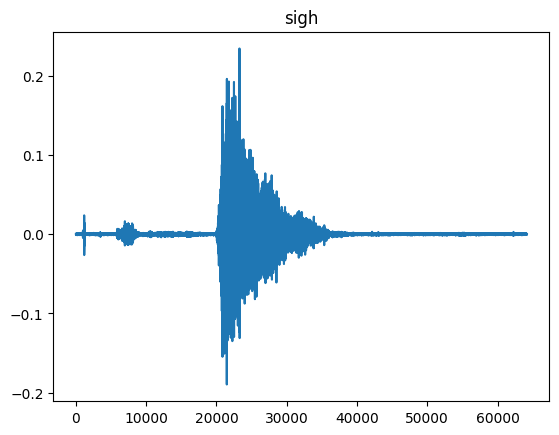

In [8]:
import matplotlib.pyplot as plt
for elem in ds_signals.take(1):
  signal, label = elem
  plt.plot(signal)
  plt.title(vocal_sounds[label])

In [9]:
for elem in ds_files:
  print(get_signal(elem).shape[0])
  break

75093


In [10]:
ds_files = tf.data.Dataset.list_files(audio_dir + '*.wav') # by default shuffle=True
len(ds_files)

20982

In [11]:
def remove_shortaudio(file_path, min_len):
  if get_signal(file_path).shape[0] < min_len:
    tf.io.gfile.remove(file_path)

initial_file_count = 21024

if len(ds_files) >= initial_file_count:
  # Remove less than 0.1s audios (16kHz then 1600 frames)
  min_len = 1600
  with ThreadPoolExecutor() as exe:
    for file in ds_files:
      exe.submit(remove_shortaudio, file.numpy(), min_len)

  ds_files = tf.data.Dataset.list_files(audio_dir + '*.wav') # by default shuffle=True

print('Total audios:', len(ds_files))

Total audios: 20982


In [12]:
ds_signals = ds_files.map(lambda x: (get_signal(x), get_label(x)), num_parallel_calls=AUTOTUNE)
for elem in ds_signals.take(1):
  print(elem)

(<tf.Tensor: shape=(57344,), dtype=float32, numpy=
array([ 0.        , -0.00039673, -0.00097656, ..., -0.00018311,
       -0.00088501, -0.00115967], dtype=float32)>, <tf.Tensor: shape=(), dtype=int64, numpy=3>)


In [13]:
vocal_sounds = ['cough', 'laughter', 'sigh', 'sneeze', 'sniff', 'throatclearing']
num_sounds = len(vocal_sounds)


def normalize(signal, label):
  # Label to onehot
  label = tf.one_hot(label, len(vocal_sounds))

  # Signal to standard length
  std_len = 64_000 # 4s
  curr_len = len(signal)
  print(curr_len, len(signal))

  if curr_len > std_len:
    rand_idx = tf.random.uniform(shape=[], maxval=curr_len-std_len, dtype=tf.int32)
    signal = signal[rand_idx:rand_idx+std_len]

  else:
    left_padding = (std_len - curr_len) // 2
    right_padding = std_len - curr_len - left_padding
    signal = tf.pad(signal, [[left_padding, right_padding]])

  return signal, label

ds_signals = ds_signals.map(normalize)

Tensor("strided_slice:0", shape=(), dtype=int32) Tensor("strided_slice_1:0", shape=(), dtype=int32)


In [14]:
for elem in ds_signals.take(2):
  print(elem)

(<tf.Tensor: shape=(64000,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(6,), dtype=float32, numpy=array([1., 0., 0., 0., 0., 0.], dtype=float32)>)
(<tf.Tensor: shape=(64000,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(6,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1.], dtype=float32)>)


In [15]:
ds_signals.element_spec

(TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 TensorSpec(shape=(6,), dtype=tf.float32, name=None))

In [16]:
num_train = len(ds_signals)

RATIO = 0.2
test_size = int(RATIO * num_train)

ds_train = ds_signals.skip(test_size)
ds_test = ds_signals.take(test_size)

In [17]:
num_train = len(ds_train)

RATIO = 0.2
validation_size = int(RATIO * num_train)

ds_fit = ds_signals.skip(validation_size)
ds_val = ds_signals.take(validation_size)

In [18]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 128
ds_fit = (
    ds_fit
    .cache()
    .shuffle(len(ds_fit))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

ds_val = (
    ds_val
    .cache()
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr=0.0001)

epoch_wait = 5
# Crear el EarlyStopping callback con la función on_train_end
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=epoch_wait, restore_best_weights=True)

# Definimos los callbacks
callbacks = [early_stopping, reduce_lr]

In [20]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(64000, 1)),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(6),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(3),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(4),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),

    Dense(64, activation='relu'),
    Dense(6, activation='softmax')  # Usar softmax para clasificación multiclase
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 63998, 64)         256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 31999, 64)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 31997, 64)         12352     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 5332, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 5330, 64)          12352     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 1776, 64)          0

In [21]:
history = model.fit(ds_fit, epochs=100, validation_data=ds_val, callbacks=callbacks)

Epoch 1/100
138/138 [==============================] - 146s 690ms/step - loss: 0.4007 - accuracy: 0.3894 - val_loss: 0.3153 - val_accuracy: 0.5895 - lr: 0.0010
Epoch 2/100
138/138 [==============================] - 89s 648ms/step - loss: 0.2903 - accuracy: 0.6335 - val_loss: 0.2637 - val_accuracy: 0.6682 - lr: 0.0010
Epoch 3/100
138/138 [==============================] - 90s 650ms/step - loss: 0.2428 - accuracy: 0.7100 - val_loss: 0.2278 - val_accuracy: 0.7319 - lr: 0.0010
Epoch 4/100
138/138 [==============================] - 89s 646ms/step - loss: 0.2085 - accuracy: 0.7593 - val_loss: 0.2173 - val_accuracy: 0.7382 - lr: 0.0010
Epoch 5/100
138/138 [==============================] - 93s 676ms/step - loss: 0.1753 - accuracy: 0.8071 - val_loss: 0.1829 - val_accuracy: 0.7995 - lr: 0.0010
Epoch 6/100
138/138 [==============================] - 93s 674ms/step - loss: 0.1485 - accuracy: 0.8391 - val_loss: 0.1766 - val_accuracy: 0.8105 - lr: 0.0010
Epoch 7/100
138/138 [========================

In [22]:
BATCH_SIZE = 128
ds_eval = (
    ds_test.cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
test_loss, test_acc = model.evaluate(ds_eval)

print('Test accuracy:', test_acc)

33/33 [==============================] - 13s 393ms/step - loss: 0.1752 - accuracy: 0.8222
Test accuracy: 0.8222116231918335


In [34]:
# model.save_weights('testnn')
model.save('Conv1D_82')

In [35]:
# Create a new model instance
mymodel = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(64000, 1)),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(6),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(3),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(4),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),

    Dense(64, activation='relu'),
    Dense(6, activation='softmax')  # Usar softmax para clasificación multiclase
])

mymodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Restore the weights
mymodel.load_weights('Conv1D_82')

BATCH_SIZE = 128
ds_eval = (
    ds_test.cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
test_loss, test_acc = mymodel.evaluate(ds_eval)

print('Test accuracy:', test_acc)

33/33 [==============================] - 13s 370ms/step - loss: 0.1694 - accuracy: 0.8348
Test accuracy: 0.8348426818847656


In [37]:
!zip -r Conv1D_82.zip Conv1D_82

  adding: Conv1D_82/ (stored 0%)
  adding: Conv1D_82/variables/ (stored 0%)
  adding: Conv1D_82/variables/variables.data-00000-of-00001 (deflated 16%)
  adding: Conv1D_82/variables/variables.index (deflated 66%)
  adding: Conv1D_82/keras_metadata.pb (deflated 93%)
  adding: Conv1D_82/saved_model.pb (deflated 88%)
  adding: Conv1D_82/fingerprint.pb (stored 0%)
  adding: Conv1D_82/assets/ (stored 0%)
